In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from utils.visualize import visualize_3d_skeleton
from models import models
import yaml
from datasets import datasets

In [2]:
label_dict = {
    0: 'drink water',
    1: 'eat meal/snack',
    2: 'brushing teeth',
    3: 'brushing hair',
    4: 'drop',
    5: 'pickup',
    6: 'throw',
    7: 'sitting down',
    8: 'standing up (from sitting position)',
    9: 'clapping',
    10: 'reading',
    11: 'writing',
    12: 'tear up paper',
    13: 'wear jacket',
    14: 'take off jacket',
    15: 'wear a shoe',
    16: 'take off a shoe',
    17: 'wear on glasses',
    18: 'take off glasses',
    19: 'put on a hat/cap',
    20: 'take off a hat/cap',
    21: 'cheer up',
    22: 'hand waving',
    23: 'kicking something',
    24: 'reach into pocket',
    25: 'hopping (one foot jumping)',
    26: 'jump up',
    27: 'make a phone call/answer phone',
    28: 'playing with phone/tablet',
    29: 'typing on a keyboard',
    30: 'pointing to something with finger',
    31: 'taking a selfie',
    32: 'check time (from watch)',
    33: 'rub two hands together',
    34: 'nod head/bow',
    35: 'shake head',
    36: 'wipe face',
    37: 'salute',
    38: 'put the palms together',
    39: 'cross hands in front (say stop)',
    40: 'sneeze/cough',
    41: 'staggering',
    42: 'falling',
    43: 'touch head (headache)',
    44: 'touch chest (stomachache/heart pain)',
    45: 'touch back (backache)',
    46: 'touch neck (neckache)',
    47: 'nausea or vomiting condition',
    48: 'use a fan (with hand or paper)/feeling warm',
    49: 'punching/slapping other person',
    50: 'kicking other person',
    51: 'pushing other person',
    52: 'pat on back of other person',
    53: 'point finger at the other person',
    54: 'hugging other person',
    55: 'giving something to other person',
    56: 'touch other person\'s pocket',
    57: 'handshaking',
    58: 'walking towards each other',
    59: 'walking apart from each other'
}

In [125]:
sv_path = 'save/nturgbd60_pretrain_tube5_T90_cls_v5/epoch-200.pth'
sv_file = torch.load(sv_path)
model = models.make(sv_file['model'], load_sd=True)
encoder = model.auto_encoder

In [3]:
config_path = './configs/pretrain_skt2vec2.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dataset = datasets.make(config['val_dataset']['dataset'])

In [14]:
data = dataset[0]
joints = data['keypoint']
motion = data['motion']
joints.shape, motion.shape

(torch.Size([1, 2, 90, 25, 3]), torch.Size([1, 2, 90, 25, 3]))

In [17]:
joints[0, 0, 1, 0] - joints[0, 0, 0, 0], motion[0, 0, 0, 0]

(tensor([ 5.6112e-05, -9.4071e-05,  2.5001e-04]),
 tensor([ 5.6112e-05, -9.4071e-05,  2.5001e-04]))

In [126]:
idx = 26
label = dataset[idx]['label'].item()
print('label:' + label_dict[label])
encoder.eval()
with torch.no_grad():
    out = encoder.forward_encoder(dataset[idx]['keypoint'])

label:jump up


In [131]:
attn = encoder.encoder.layers[-1].attn.get_attn_matrix()
# attn_reduce = attn.sum(dim=1) / attn.size(1)
attn_reduce = attn[:, -1, :, :]
cls_attn = attn_reduce[:, 0, 1:]
cls_attn_softmax = F.softmax(cls_attn, dim=1)
cls_attn_softmax_nor = (cls_attn_softmax - cls_attn_softmax.min()) / (cls_attn_softmax.max() - cls_attn_softmax.min())

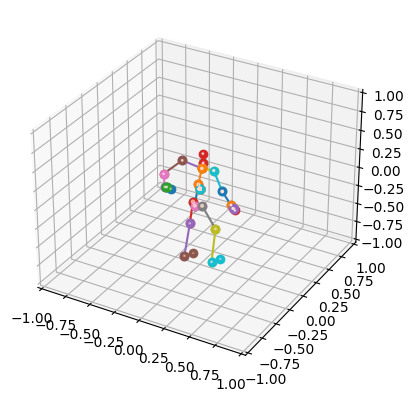

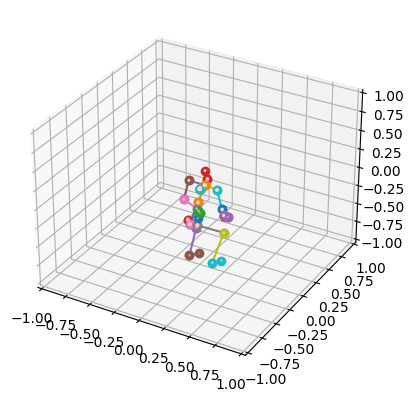

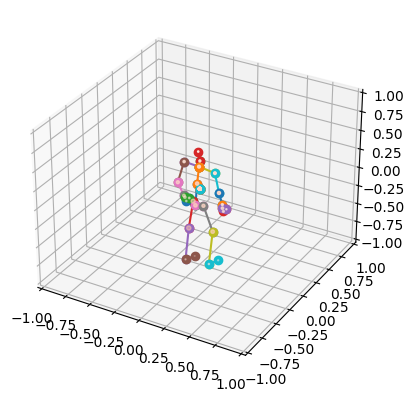

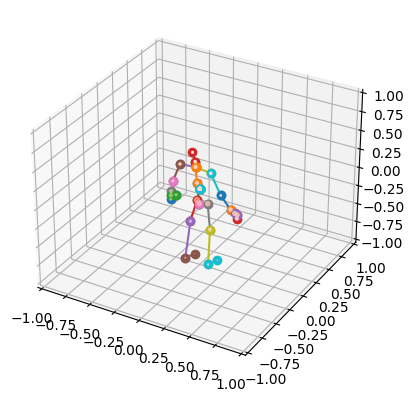

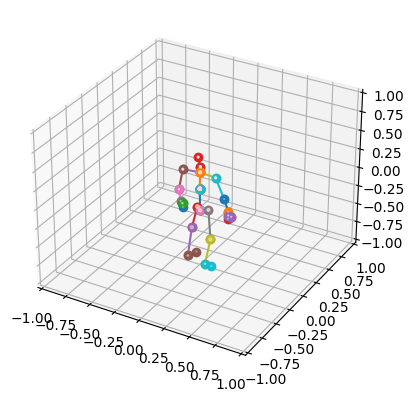

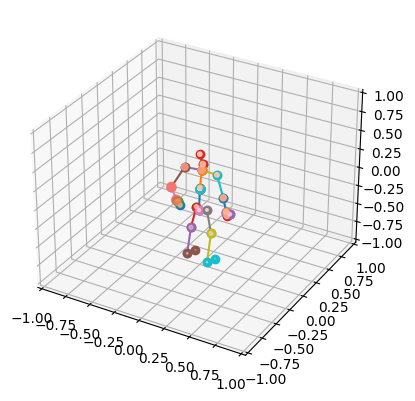

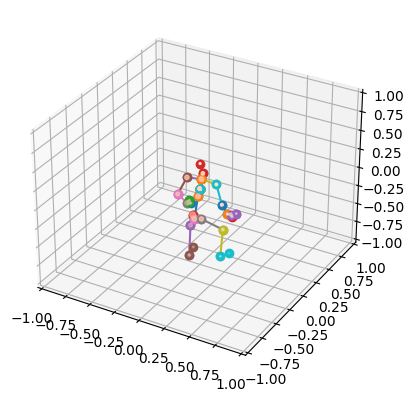

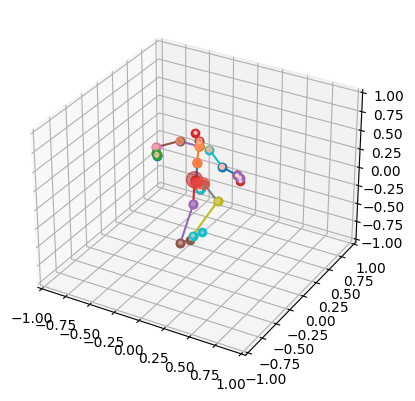

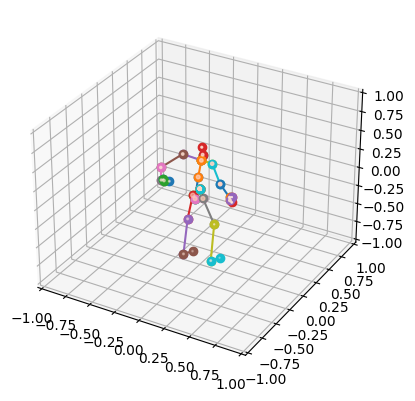

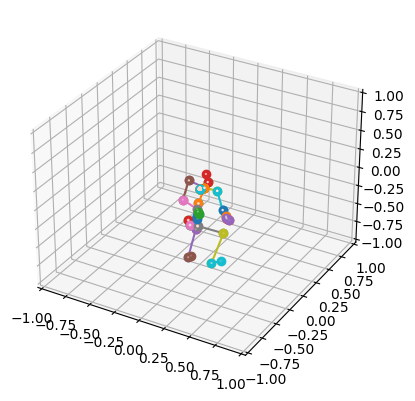

In [132]:
T, V = 30, 25
attn_score = cls_attn_softmax_nor.view(-1, T, V).repeat_interleave(3, dim=1).numpy()
data = dataset[idx]['keypoint'][0].numpy()
visualize_3d_skeleton(data, attn_score, time_interval=9)

# motion aware tube masking

In [1]:
import torch
import torch.nn.functional as F
from einops import rearrange, reduce
import numpy as np
from utils.visualize import visualize_3d_skeleton
from models import models
import yaml
from datasets import datasets
from torch.utils.data import DataLoader

In [5]:
config_path = './configs/ntu120xset_pretrain_skt2vec2.yaml'
# config_path = 'configs/pkuv1_xsub/pretrain_skt2vec2.yaml'
# config_path = './configs/pretrain_skt2vec2.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dataset = datasets.make(config['train_dataset']['dataset'])

In [6]:
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [7]:
len(dataloader)

213

In [3]:
data = dataset[500]
x = data['keypoint'].unsqueeze(0)
x_motion = data['motion'].unsqueeze(0)
s = 3
x = rearrange(x, 'b n m (t s) v c -> (b n m) t v (s c)', s=s)
x_motion = rearrange(x_motion, 'b n m (t s) v c -> (b n m) t v (s c)', s=s)
x.shape, x_motion.shape

(torch.Size([2, 30, 25, 9]), torch.Size([2, 30, 25, 9]))

In [4]:
x_motion_temp_att = x_motion.clone()
# motion_intensity = x_motion_temp_att.pow(2)
motion_intensity = x_motion_temp_att.abs()
x_motion_temp_att = reduce(motion_intensity, 'n t v c -> n t', 'mean')
# x_motion_temp_att = x_motion_temp_att / (x_motion_temp_att.sum(dim=1, keepdim=True) + 1e-6)
x_motion_temp_att = x_motion_temp_att / (x_motion_temp_att.max(dim=1, keepdim=True).values + 1e-6)
x_motion_temp_att = F.softmax(x_motion_temp_att, dim=1)
x_motion_temp_att.shape

torch.Size([2, 30])

In [71]:
x_motion_temp_att = x_motion.clone()
# motion_intensity = x_motion_temp_att.pow(2)
motion_intensity = x_motion_temp_att.abs()
x_motion_temp_att = reduce(motion_intensity, 'n t v c -> n t v', 'mean')
B, T, V = x_motion_temp_att.shape
x_motion_temp_att = x_motion_temp_att.view(B, T // 5, 5, V).mean(dim=2)
x_motion_temp_att = x_motion_temp_att / (x_motion_temp_att.max(dim=1, keepdim=True).values + 1e-6)
# x_motion_temp_att = F.softmax(x_motion_temp_att / 0.5, dim=2)

In [24]:
x_motion_temp_att

tensor([[[0.1106, 0.2001, 0.2267, 0.4559, 0.0799, 0.2236, 0.4267, 0.7348,
          0.0184, 0.2427, 0.9327, 0.7062, 0.0977, 0.6591, 0.9997, 0.9999,
          0.1386, 0.5628, 0.3252, 0.1129, 0.2882, 0.8106, 0.5380, 0.9907,
          0.6965],
         [0.9995, 0.7249, 0.6459, 0.5456, 0.2946, 0.9999, 0.9999, 0.9999,
          0.1281, 0.9998, 0.9999, 0.9999, 0.9996, 0.7436, 0.6779, 0.7398,
          0.9996, 0.9739, 0.3972, 0.4941, 0.5609, 1.0000, 1.0000, 0.9297,
          0.9999],
         [0.8231, 0.9991, 0.9955, 0.9996, 0.9999, 0.2657, 0.5931, 0.2241,
          0.2168, 0.9167, 0.8492, 0.6374, 0.6866, 0.5333, 0.7432, 0.6186,
          0.7715, 0.6969, 0.3537, 0.1527, 0.9994, 0.2591, 0.2580, 0.7599,
          0.8841],
         [0.5757, 0.7465, 0.8599, 0.2699, 0.0959, 0.0765, 0.1003, 0.1058,
          0.9999, 0.8117, 0.5791, 0.6663, 0.4672, 0.9994, 0.9518, 0.6333,
          0.5473, 0.9992, 0.3935, 0.4711, 0.7661, 0.2618, 0.3019, 0.9999,
          0.9403],
         [0.1362, 0.5676, 0.9995, 0.

In [ ]:
def tube_masking(self, x, x_motion, mask_ratio, tube_len, tau=0.2):
    N, L, D = x.shape  # batch, length, dim
    VP, TP = 25, 30
    len_VP_keep = int(VP * (1 - mask_ratio))
    s = 3

    assert TP % tube_len == 0
    TP_ = TP // tube_len

    x_motion = rearrange(x_motion, 'b n m (t s) v c -> (b n m) t v (s c)', s=s)
    motion_intensity = x_motion.abs()
    motion_intensity = reduce(motion_intensity, 'n t v c -> n t v', 'mean')
    motion_intensity = motion_intensity.view(-1, TP_, tube_len, VP).mean(dim=2)
    motion_intensity = motion_intensity / (motion_intensity.max(dim=1, keepdim=True).values + 1e-6)

    # Divide the dimension of time into several tubes
    noise = torch.rand(N, TP_, VP, device=x.device)  # noise in [0, 1]
    noise = noise + tau * motion_intensity

    # sort noise for each sample
    ids_shuffle = torch.argsort(
        noise, dim=-1
    )  # ascend: small is keep, large is remove
    ids_restore = torch.argsort(ids_shuffle, dim=-1)

    # Fill the tubes to restore the original dimension of time
    ids_shuffle = ids_shuffle.repeat_interleave(tube_len, dim=1)
    ids_restore = ids_restore.repeat_interleave(tube_len, dim=1)

    # shift tube
    # shift = torch.randint(low=0, high=ids_shuffle.size(1), size=(1,)).item()
    # ids_shuffle = torch.roll(ids_shuffle, shifts=shift, dims=1)
    # ids_restore = torch.roll(ids_restore, shifts=shift, dims=1)

    # keep the first subset
    ids_keep = ids_shuffle[:, :, :len_VP_keep]
    x_masked = torch.gather(x.view(N, TP, VP, D), dim=2,
                            index=ids_keep.unsqueeze(-1).repeat(1, 1, 1, D))
    x_masked = rearrange(x_masked, 'n t v d -> n (t v) d')

    # generate the binary mask: 0 is keep, 1 is remove
    mask = torch.ones([N, TP, VP], device=x.device)
    mask[:, :, :len_VP_keep] = 0
    # unshuffle to get the binary mask
    mask = torch.gather(mask, dim=2, index=ids_restore)
    mask = rearrange(mask, 'n t v -> n (t v)')

    return x_masked, mask, ids_restore, ids_keep

In [8]:
accum_att = 0
tau = 0.15
segment_state = torch.zeros_like(x_motion_temp_att)
for i in range(x.shape[1]):
    accum_att += x_motion_temp_att[:, i]
    is_segment_end = (accum_att > tau)
    # if true, update
    if i > 0:
        segment_state[:, i-1] = is_segment_end
        accum_att = torch.where(is_segment_end, x_motion_temp_att[:, i], accum_att)
    else:
        segment_state[:, i] = is_segment_end
        accum_att = torch.where(is_segment_end, 0, accum_att)
segment_state[:, -1] = True
    # print(segment_state)
    # break

In [9]:
masked_views = segment_state.sum(dim=1).max()
masked_views = int(masked_views.item())

In [10]:
segment_state, masked_views

(tensor([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
          1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.],
         [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
          0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.]]),
 8)

In [102]:
spatioal_attn = torch.zeros((2, masked_views, 25))
masked_views_idxs = torch.zeros((2,), dtype=torch.long)
masked_views_idxs

tensor([0, 0])

In [103]:
spatioal_attn[torch.arange(2), masked_views_idxs].shape

torch.Size([2, 25])

In [104]:
accum_spa_attn = 0
motion_intensity_ = motion_intensity.mean(dim=-1)
segment_state = segment_state.bool()
for i in range(segment_state.shape[1]):
    accum_spa_attn += motion_intensity_[:, i]
    spatioal_attn[torch.arange(spatioal_attn.size(0)), masked_views_idxs] = accum_spa_attn
    masked_views_idxs = torch.where(segment_state[:, i], masked_views_idxs + 1, masked_views_idxs)
    accum_spa_attn = torch.where(segment_state[:, i, None].repeat(1, 1, 25), 0, accum_spa_attn)
spatioal_attn

tensor([[[0.0108, 0.0071, 0.0099, 0.0136, 0.0083, 0.0124, 0.0378, 0.0398,
          0.0117, 0.0201, 0.0702, 0.0910, 0.0121, 0.0254, 0.0194, 0.1221,
          0.0108, 0.0312, 0.0280, 0.1361, 0.0083, 0.0535, 0.1275, 0.1043,
          0.1263],
         [0.0104, 0.0063, 0.0106, 0.0143, 0.0070, 0.0259, 0.0360, 0.0369,
          0.0218, 0.0486, 0.0517, 0.0644, 0.0131, 0.0241, 0.0338, 0.1649,
          0.0101, 0.0269, 0.0305, 0.0725, 0.0091, 0.0541, 0.0933, 0.1291,
          0.1047],
         [0.0045, 0.0041, 0.0065, 0.0067, 0.0061, 0.0136, 0.1024, 0.0677,
          0.0060, 0.0172, 0.0139, 0.0255, 0.0047, 0.0294, 0.0156, 0.1839,
          0.0042, 0.0137, 0.0400, 0.1391, 0.0054, 0.0906, 0.1055, 0.0909,
          0.0825],
         [0.0055, 0.0049, 0.0048, 0.0078, 0.0046, 0.0086, 0.0123, 0.0135,
          0.0159, 0.0377, 0.0889, 0.0882, 0.0060, 0.0069, 0.0067, 0.1120,
          0.0054, 0.0066, 0.0098, 0.0739, 0.0052, 0.0203, 0.0181, 0.0965,
          0.0903]],

        [[0.2786, 0.1950, 0.1740, 

In [105]:
# spatioal_attn = spatioal_attn / (spatioal_attn.max(dim=-1, keepdim=True).values + 1e-8)
spatioal_attn = spatioal_attn / (spatioal_attn.sum(dim=-1, keepdim=True) + 1e-8)

In [107]:
spatioal_attn = F.softmax(spatioal_attn, dim=-1)

In [125]:
spatioal_attn

tensor([[[0.0293, 0.0285, 0.0291, 0.0299, 0.0287, 0.0296, 0.0357, 0.0362,
          0.0295, 0.0313, 0.0453, 0.0528, 0.0295, 0.0326, 0.0312, 0.0664,
          0.0293, 0.0340, 0.0332, 0.0735, 0.0287, 0.0401, 0.0690, 0.0582,
          0.0684],
         [0.0315, 0.0308, 0.0316, 0.0323, 0.0309, 0.0347, 0.0368, 0.0371,
          0.0338, 0.0398, 0.0405, 0.0438, 0.0321, 0.0343, 0.0364, 0.0805,
          0.0315, 0.0349, 0.0356, 0.0460, 0.0313, 0.0411, 0.0522, 0.0648,
          0.0559],
         [0.0311, 0.0311, 0.0315, 0.0315, 0.0314, 0.0327, 0.0530, 0.0439,
          0.0314, 0.0334, 0.0328, 0.0349, 0.0312, 0.0357, 0.0331, 0.0826,
          0.0311, 0.0327, 0.0378, 0.0648, 0.0313, 0.0497, 0.0539, 0.0498,
          0.0476],
         [0.0304, 0.0302, 0.0302, 0.0310, 0.0301, 0.0312, 0.0323, 0.0326,
          0.0333, 0.0405, 0.0639, 0.0635, 0.0305, 0.0307, 0.0307, 0.0786,
          0.0303, 0.0307, 0.0315, 0.0559, 0.0303, 0.0347, 0.0340, 0.0684,
          0.0647]],

        [[0.0364, 0.0321, 0.0311, 

In [123]:
noise = torch.log(spatioal_attn)\
    - torch.log(-torch.log(torch.rand(2, masked_views, 25, device=x.device) + 1e-6) + 1e-6)

In [ ]:
spatioal_attn

In [124]:
noise

tensor([[[-1.6192, -0.8519, -4.6775, -2.1217, -2.6461, -3.0054, -0.0186,
          -2.5638, -3.8202, -2.5122, -0.7295, -3.7688, -4.0639, -4.4414,
          -2.6782, -1.8788, -1.3251, -0.5257, -3.6733, -1.8402, -1.6387,
          -3.5745, -2.4511, -1.7174, -2.5879],
         [-2.9855, -4.4418, -3.2469, -5.3343, -3.8392, -4.3037, -1.4596,
          -2.4919, -3.0992, -2.9912, -0.6312, -2.2655, -4.2515, -2.5335,
          -2.5175, -1.8082, -2.5678, -4.2032, -3.4793, -1.1428, -2.7557,
          -1.7607, -2.3253,  1.5479, -3.1940],
         [-3.3622, -5.1392, -2.7916, -3.3857, -3.6972, -2.1362, -0.5294,
          -3.2824,  0.4104, -4.3743, -2.0019, -1.6669, -2.1421,  4.2825,
          -2.1300, -2.9734, -3.4665, -4.0174, -4.2013, -1.4820, -3.8983,
          -2.7207, -1.8275, -3.6357,  1.2787],
         [-2.7734, -1.2666, -2.6462, -1.6402, -4.4256, -3.6804, -2.5098,
          -3.0699, -2.3534, -3.0713, -2.8586, -2.3179, -3.9656, -2.2088,
          -3.4836, -3.0961, -0.0273, -3.0187, -3.0598, -

In [51]:
spatioal_attn.shape, masked_views_idxs.shape, accum_spa_attn.shape

(torch.Size([2, 8, 25]), torch.Size([2]), torch.Size([2, 25, 9]))

In [9]:
# segment_state_ = segment_state.clone()
segment_state_ = segment_state.cumsum(dim=1)
segment_state_[segment_state == 1] -= 1
segment_state_, segment_state_.shape

(tensor([[0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4.,
          4., 4., 5., 5., 5., 5., 6., 6., 6., 6., 7., 7.],
         [0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4.,
          4., 4., 5., 5., 5., 5., 6., 6., 6., 6., 7., 7.]]),
 torch.Size([2, 30]))

In [70]:
N = 2; TP_ = masked_views; VP = 25
noise = torch.rand(N, TP_, VP)
ids_shuffle = torch.argsort(
    noise, dim=-1
)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=-1)
ids_shuffle.shape, ids_restore.shape

(torch.Size([2, 5, 25]), torch.Size([2, 5, 25]))

In [72]:
ids_shuffle = torch.gather(ids_shuffle, dim=1,
                           index=segment_state_.unsqueeze(-1).repeat(1, 1, VP).long()
                           )
ids_restore = torch.gather(ids_restore, dim=1,
                           index=segment_state_.unsqueeze(-1).repeat(1, 1, VP).long()
                           )
ids_shuffle.shape, ids_restore.shape

(torch.Size([2, 30, 25]), torch.Size([2, 30, 25]))

In [ ]:
TP = 30
ids_keep = ids_shuffle[:, :, :4]
x_masked = torch.gather(x.view(N, TP, VP, -1), dim=2,
                        index=ids_keep.unsqueeze(-1).repeat(1, 1, 1, D))

# lr decay

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# ELECTRA https://github.com/google-research/electra
# BEiT: https://github.com/microsoft/unilm/tree/master/beit
# --------------------------------------------------------

import json


def param_groups_lrd(model, weight_decay=0.05, no_weight_decay_list=[], layer_decay=.75):
    """
    Parameter groups for layer-wise lr decay
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L58
    """
    param_group_names = {}
    param_groups = {}

    # num_layers = len(model.blocks) + 1
    num_layers = len(model.encoder.encoder.layers) + 1

    layer_scales = list(layer_decay ** (num_layers - i) for i in range(num_layers + 1))

    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue

        # no decay: all 1D parameters and model specific ones
        if p.ndim == 1 or n in no_weight_decay_list:
            g_decay = "no_decay"
            this_decay = 0.
        else:
            g_decay = "decay"
            this_decay = weight_decay
            
        layer_id = get_layer_id_for_vit(n, num_layers)
        group_name = "layer_%d_%s" % (layer_id, g_decay)

        if group_name not in param_group_names:
            this_scale = layer_scales[layer_id]

            param_group_names[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }
            param_groups[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }

        param_group_names[group_name]["params"].append(n)
        param_groups[group_name]["params"].append(p)

    print("parameter groups: \n%s" % json.dumps(param_group_names, indent=2))
    return param_groups

    # return list(param_groups.values())


def get_layer_id_for_vit(name, num_layers):
    """
    Assign a parameter with its layer id
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L33
    """
    # if name in ['temp_embed', 'pos_embed']:
    #     return 0
    if name.startswith('encoder.encoder_embedding'):
        return 0
    elif name.startswith('encoder.encoder.'):
        return int(name.split('.')[3]) + 1
    elif name.startswith('encoder.encoder_norm'):
        return num_layers - 1
    else:
        return num_layers

In [1]:
import torch.nn as nn
def param_groups_weight_decay(
        model: nn.Module,
        weight_decay=1e-5,
        no_weight_decay_list=()
):
    no_weight_decay_list = set(no_weight_decay_list)
    decay = []
    no_decay = []
    decay_names = []
    no_decay_names = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue

        if param.ndim <= 1 or name.endswith(".bias") or name in no_weight_decay_list:
            no_decay.append(param)
            no_decay_names.append(name)
        else:
            decay.append(param)
            decay_names.append(name)

    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay},
        {'params_names': no_decay_names, 'weight_decay': 0.},
        {'params_names': decay_names, 'weight_decay': weight_decay}]

In [3]:
import torch
import yaml
from models import models
import timm.optim.optim_factory as optim_factory

path = 'configs/ntu60_xsub/fine_tune.yaml'
with open(path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    print('config loaded.')

# sv_path = 'save/nturgbd60_pretrain_skt2vec2_tube_9997EMA/epoch-last-rank0.pth'
# ckp = torch.load(sv_path)
# model_0 = models.make(ckp['model'], load_sd=True)
# sv_path = 'save/nturgbd60_pretrain_skt2vec2_tube_9997EMA/epoch-last-rank1.pth'
# ckp = torch.load(sv_path)
# model_1 = models.make(ckp['model'], load_sd=True)
model = models.make(config['model'])

config loaded.


In [5]:
import utils

In [7]:
no_wd = model.no_weight_decay()
param_groups = param_groups_lrd(model, 5e-2, no_wd)

parameter groups: 
{
  "layer_9_decay": {
    "lr_scale": 1.0,
    "weight_decay": 0.05,
    "params": [
      "encoder.decoder_spatio_pos_emb",
      "encoder.decoder_temporal_pos_emb",
      "encoder.mask_token_emb",
      "encoder.decoder_embedding.weight",
      "encoder.decoder.layers.0.attn.keys.weight",
      "encoder.decoder.layers.0.attn.queries.weight",
      "encoder.decoder.layers.0.attn.values.weight",
      "encoder.decoder.layers.0.attn.proj.weight",
      "encoder.decoder.layers.0.mlp.fc1.weight",
      "encoder.decoder.layers.0.mlp.fc2.weight",
      "encoder.decoder.layers.1.attn.keys.weight",
      "encoder.decoder.layers.1.attn.queries.weight",
      "encoder.decoder.layers.1.attn.values.weight",
      "encoder.decoder.layers.1.attn.proj.weight",
      "encoder.decoder.layers.1.mlp.fc1.weight",
      "encoder.decoder.layers.1.mlp.fc2.weight",
      "encoder.decoder.layers.2.attn.keys.weight",
      "encoder.decoder.layers.2.attn.queries.weight",
      "encoder.decod

In [8]:
param_groups[-2]

{'params_names': ['encoder.encoder_embedding.spatio_pos_emb',
  'encoder.encoder_embedding.temporal_pos_emb',
  'encoder.encoder_embedding.projection.1.bias',
  'encoder.encoder.layers.0.gamma_1',
  'encoder.encoder.layers.0.gamma_2',
  'encoder.encoder.layers.0.norm1.weight',
  'encoder.encoder.layers.0.norm1.bias',
  'encoder.encoder.layers.0.attn.keys.bias',
  'encoder.encoder.layers.0.attn.queries.bias',
  'encoder.encoder.layers.0.attn.values.bias',
  'encoder.encoder.layers.0.attn.proj.bias',
  'encoder.encoder.layers.0.norm2.weight',
  'encoder.encoder.layers.0.norm2.bias',
  'encoder.encoder.layers.0.mlp.fc1.bias',
  'encoder.encoder.layers.0.mlp.fc2.bias',
  'encoder.encoder.layers.1.gamma_1',
  'encoder.encoder.layers.1.gamma_2',
  'encoder.encoder.layers.1.norm1.weight',
  'encoder.encoder.layers.1.norm1.bias',
  'encoder.encoder.layers.1.attn.keys.bias',
  'encoder.encoder.layers.1.attn.queries.bias',
  'encoder.encoder.layers.1.attn.values.bias',
  'encoder.encoder.layers.

In [47]:
for name, param in model.named_parameters():
    if name in {'auto_encoder.decoder_spatio_pos_emb', 'auto_encoder.decoder_temporal_pos_emb',
                'auto_encoder.encoder_embedding.spatio_pos_emb', 'auto_encoder.encoder_embedding.temporal_pos_emb'}:
                print(name)

auto_encoder.decoder_spatio_pos_emb
auto_encoder.decoder_temporal_pos_emb
auto_encoder.encoder_embedding.spatio_pos_emb
auto_encoder.encoder_embedding.temporal_pos_emb


In [34]:
model_0_ema = model_0.ema
model_1_ema = model_1.ema

In [40]:
for param in model_0_ema.parameters():
    print(param[0])

tensor([[[-0.0187, -0.0189, -0.0474,  ..., -0.0098, -0.0125, -0.0135]],

        [[ 0.0056,  0.0200,  0.0267,  ...,  0.0012, -0.0353,  0.0470]],

        [[ 0.0280, -0.0095, -0.0072,  ...,  0.0305,  0.0321,  0.0126]],

        ...,

        [[ 0.0025, -0.0088,  0.0310,  ..., -0.0043,  0.0190,  0.0311]],

        [[ 0.0256, -0.0182, -0.0366,  ..., -0.0064,  0.0032, -0.0297]],

        [[ 0.0169,  0.0174,  0.0186,  ..., -0.0208, -0.0049, -0.0179]]])
tensor([[[ 0.0108],
         [ 0.0107],
         [ 0.0221],
         ...,
         [ 0.0238],
         [-0.0059],
         [ 0.0028]],

        [[ 0.0100],
         [-0.0347],
         [-0.0178],
         ...,
         [-0.0059],
         [ 0.0334],
         [ 0.0140]],

        [[ 0.0042],
         [-0.0234],
         [ 0.0144],
         ...,
         [ 0.0043],
         [-0.0313],
         [ 0.0043]],

        ...,

        [[ 0.0043],
         [ 0.0119],
         [ 0.0078],
         ...,
         [ 0.0068],
         [ 0.0085],
         [ 0

In [41]:
for param in model_1_ema.parameters():
    print(param[0])

tensor([[[-0.0187, -0.0189, -0.0474,  ..., -0.0098, -0.0125, -0.0135]],

        [[ 0.0056,  0.0200,  0.0267,  ...,  0.0012, -0.0353,  0.0470]],

        [[ 0.0280, -0.0095, -0.0072,  ...,  0.0305,  0.0321,  0.0126]],

        ...,

        [[ 0.0025, -0.0088,  0.0310,  ..., -0.0043,  0.0190,  0.0311]],

        [[ 0.0256, -0.0182, -0.0366,  ..., -0.0064,  0.0032, -0.0297]],

        [[ 0.0169,  0.0174,  0.0186,  ..., -0.0208, -0.0049, -0.0179]]])
tensor([[[ 0.0108],
         [ 0.0107],
         [ 0.0221],
         ...,
         [ 0.0238],
         [-0.0059],
         [ 0.0028]],

        [[ 0.0100],
         [-0.0347],
         [-0.0178],
         ...,
         [-0.0059],
         [ 0.0334],
         [ 0.0140]],

        [[ 0.0042],
         [-0.0234],
         [ 0.0144],
         ...,
         [ 0.0043],
         [-0.0313],
         [ 0.0043]],

        ...,

        [[ 0.0043],
         [ 0.0119],
         [ 0.0078],
         ...,
         [ 0.0068],
         [ 0.0085],
         [ 0

In [ ]:
groups = param_groups_lrd(model)

In [2]:
model

SkTForClassification(
  (encoder): SkTWithDecoder(
    (encoder_embedding): JointEmbedding(
      (projection): Sequential(
        (0): Rearrange('B N M T V C -> (B N M) C T V')
        (1): Conv2d(3, 256, kernel_size=(3, 1), stride=(3, 1))
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderBlock(
          (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (attn): MultiHeadAttention(
            (keys): Linear(in_features=256, out_features=256, bias=True)
            (queries): Linear(in_features=256, out_features=256, bias=True)
            (values): Linear(in_features=256, out_features=256, bias=True)
            (att_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (mlp): FeedForwardBlock(
            (fc1): Linear(in_features=256, out_features=1024,

In [24]:
from torch.optim import AdamW

In [25]:
AdamW(model.parameters(), lr=0.00001, weight_decay=0.01)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0.01
)

# Test

In [1]:
import math
import sys
import os
from functools import partial

import yaml
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import wandb

import utils
from datasets import datasets
from models import models

In [2]:
label_dict = {
    0: 'drink water',
    1: 'eat meal/snack',
    2: 'brushing teeth',
    3: 'brushing hair',
    4: 'drop',
    5: 'pickup',
    6: 'throw',
    7: 'sitting down',
    8: 'standing up (from sitting position)',
    9: 'clapping',
    10: 'reading',
    11: 'writing',
    12: 'tear up paper',
    13: 'wear jacket',
    14: 'take off jacket',
    15: 'wear a shoe',
    16: 'take off a shoe',
    17: 'wear on glasses',
    18: 'take off glasses',
    19: 'put on a hat/cap',
    20: 'take off a hat/cap',
    21: 'cheer up',
    22: 'hand waving',
    23: 'kicking something',
    24: 'reach into pocket',
    25: 'hopping (one foot jumping)',
    26: 'jump up',
    27: 'make a phone call/answer phone',
    28: 'playing with phone/tablet',
    29: 'typing on a keyboard',
    30: 'pointing to something with finger',
    31: 'taking a selfie',
    32: 'check time (from watch)',
    33: 'rub two hands together',
    34: 'nod head/bow',
    35: 'shake head',
    36: 'wipe face',
    37: 'salute',
    38: 'put the palms together',
    39: 'cross hands in front (say stop)',
    40: 'sneeze/cough',
    41: 'staggering',
    42: 'falling',
    43: 'touch head (headache)',
    44: 'touch chest (stomachache/heart pain)',
    45: 'touch back (backache)',
    46: 'touch neck (neckache)',
    47: 'nausea or vomiting condition',
    48: 'use a fan (with hand or paper)/feeling warm',
    49: 'punching/slapping other person',
    50: 'kicking other person',
    51: 'pushing other person',
    52: 'pat on back of other person',
    53: 'point finger at the other person',
    54: 'hugging other person',
    55: 'giving something to other person',
    56: 'touch other person\'s pocket',
    57: 'handshaking',
    58: 'walking towards each other',
    59: 'walking apart from each other',
    60: 'put on headphone',
    61: 'take off headphone',
    62: 'shoot at the basket',
    63: 'bounce ball',
    64: 'tennis bat swing',
    65: 'juggling table tennis balls',
    66: 'hush (quite)',
    67: 'flick hair',
    68: 'thumb up',
    69: 'thumb down',
    70: 'make ok sign',
    71: 'make victory sign',
    72: 'staple book',
    73: 'counting money',
    74: 'cutting nails',
    75: 'cutting paper (using scissors)',
    76: 'snapping fingers',
    77: 'open bottle',
    78: 'sniff (smell)',
    79: 'squat down',
    80: 'toss a coin',
    81: 'fold paper',
    82: 'ball up paper',
    83: 'play magic cube',
    84: 'apply cream on face',
    85: 'apply cream on hand back',
    86: 'put on bag',
    87: 'take off bag',
    88: 'put something into a bag',
    89: 'take something out of a bag',
    90: 'open a box',
    91: 'move heavy objects',
    92: 'shake fist',
    93: 'throw up cap/hat',
    94: 'hands up (both hands)',
    95: 'cross arms',
    96: 'arm circles',
    97: 'arm swings',
    98: 'running on the spot',
    99: 'butt kicks (kick backward)',
    100: 'cross toe touch',
    101: 'side kick',
    102: 'yawn',
    103: 'stretch oneself',
    104: 'blow nose',
    105: 'hit other person with something',
    106: 'wield knife towards other person',
    107: 'knock over other person (hit with body)',
    108: 'grab other person’s stuff',
    109: 'shoot at other person with a gun',
    110: 'step on foot',
    111: 'high-five',
    112: 'cheers and drink',
    113: 'carry something with other person',
    114: 'take a photo of other person',
    115: 'follow other person',
    116: 'whisper in other person’s ear',
    117: 'exchange things with other person',
    118: 'support somebody with hand',
    119: 'finger-guessing game (playing rock-paper-scissors)'
}

In [3]:
def make_data_loader(spec, tag=''):
    if spec is None:
        return None
    
    dataset = datasets.make(spec['dataset'])

    loader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=spec.get('num_workers', 0),
        pin_memory=True,
        # sampler=DistributedSampler(dataset, shuffle=(tag == 'train'))
    )
    return loader

def make_test_data_loader(config):
    test_loader = make_data_loader(config.get('test_dataset'), tag='test')
    return test_loader

def load_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    # # 定义前缀
    # prefix = 'module.'

    # # 去除键的前缀
    # checkpoint['model']['sd'] = {key.replace(prefix, ''): value for key, value in checkpoint['model']['sd'].items() if key.startswith(prefix)}
    model = models.make(checkpoint['model'], load_sd=True)
    return model

In [4]:
device = 'cuda:3'
path = './configs/ntu120_xsub/test.yaml'
with open(path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
test_loader = make_test_data_loader(config)
model = load_model(config['ckp_path'])
model = model.to(device)

In [5]:
wrong_cases = dict()
model.eval()
for batch in tqdm(test_loader):
    with torch.no_grad():
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
        inp = batch['keypoint']
        labels = batch['label'].squeeze(-1)
        feat = model.extract_feat(inp)
        # print(feats[0])
        break
        # preds = logits.argmax(dim=1)
        # if preds == labels:
        #     continue
        # else:
        #     wrong_cases[batch['frame_dir'][0]] = {
        #         'total_frames': batch['total_frames'].cpu().numpy(),
        #         'pred': preds.cpu().numpy(),
        #         'label': labels.cpu().numpy(),
        #     }


  0%|          | 0/50919 [00:03<?, ?it/s]


In [9]:
feat[0].shape

torch.Size([20, 750, 256])

In [28]:
len(wrong_cases)

6105

In [35]:
for k, v in wrong_cases.items():
    v['total_frames'] = v['total_frames'].item()
    # v['pred'] = label_dict[v['pred'].item()]
    # v['label'] = label_dict[v['label'].item()]

In [36]:
import json

# 将字典保存为文本文件
with open("ntu120_xsub_wrong_cases.txt", "w") as file:
    json.dump(wrong_cases, file, indent=4)

In [38]:
my_dict = {}
for k, v in label_dict.items():
    my_dict[v] = 0

In [61]:
cnt = 0
for k, v in wrong_cases.items():
    frames = v['total_frames']
    if frames > 90:
        cnt+=1
print(cnt)

1352


In [45]:
(50919 - len(wrong_cases) + 1000) / 50919

0.8997427286474597

In [59]:
len(wrong_cases)

6105

# 2D visualization

In [13]:
import yaml
from datasets import datasets
config_path = './configs/pretrain_skt2vec2.yaml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dataset = datasets.make(config['val_dataset']['dataset'])

In [14]:
dataset[0]['keypoint'].shape

torch.Size([1, 2, 90, 25, 3])

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

In [86]:
def visualize_2d_skeleton(data, time_interval: int = 10, colors=None):
    """visualize 2d skeleton with attention

    Args:
        data (_type_): skeleton (M T V C)
        attention_scores (_type_, optional): joint attention score (M, T, V). Defaults to None.
        time_interval (int, optional): time interval for display. Defaults to 10.
        colors (_type_, optional): colors for each skeleton point. Defaults to None.
    """
    M, T, _, _ = data.shape
    # 遍历每个人的每一帧，进行可视化
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    for i, j in enumerate(range(0, T, time_interval)):
        # 创建一个图形对象
        # fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
        ax_row, ax_col = divmod(i, 5)
        ax = axes[ax_row, ax_col]

        # 获取当前帧的关节点坐标数据
        joints = data[:, j, :, :]

        # 绘制关节点之间的连线
        bones = ((0, 1), (1, 20), (2, 20), (3, 2), (4, 20),
                 (5, 4), (6, 5), (7, 6), (8, 20), (9, 8),
                 (10, 9), (11, 10), (12, 0), (13, 12),
                 (14, 13), (15, 14), (16, 0), (17, 16),
                 (18, 17), (19, 18), (21, 22), (20, 20),
                 (22, 7), (23, 24), (24, 11))

        # 绘制关节点
        if colors is None:
            for k in range(M):
                # color = plt.cm.get_cmap('Reds')(scores[k])
                ax.scatter(joints[k, :, 0], joints[k, :, 2],
                           marker='o')
                for b in bones:
                    ax.plot(joints[k, b, 0], joints[k, b, 2], '-o')
        else:
            for k in range(M):
                color = colors[k]
                ax.scatter(joints[k, :, 0], joints[k, :, 2],
                           marker='o', color=color)
                for b in bones:
                    ax.plot(joints[k, b, 0], joints[k, b, 2], '-o', color=color)

        # 设置坐标轴范围
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])

        # 显示图形
        # plt.show()

label:tear up paper


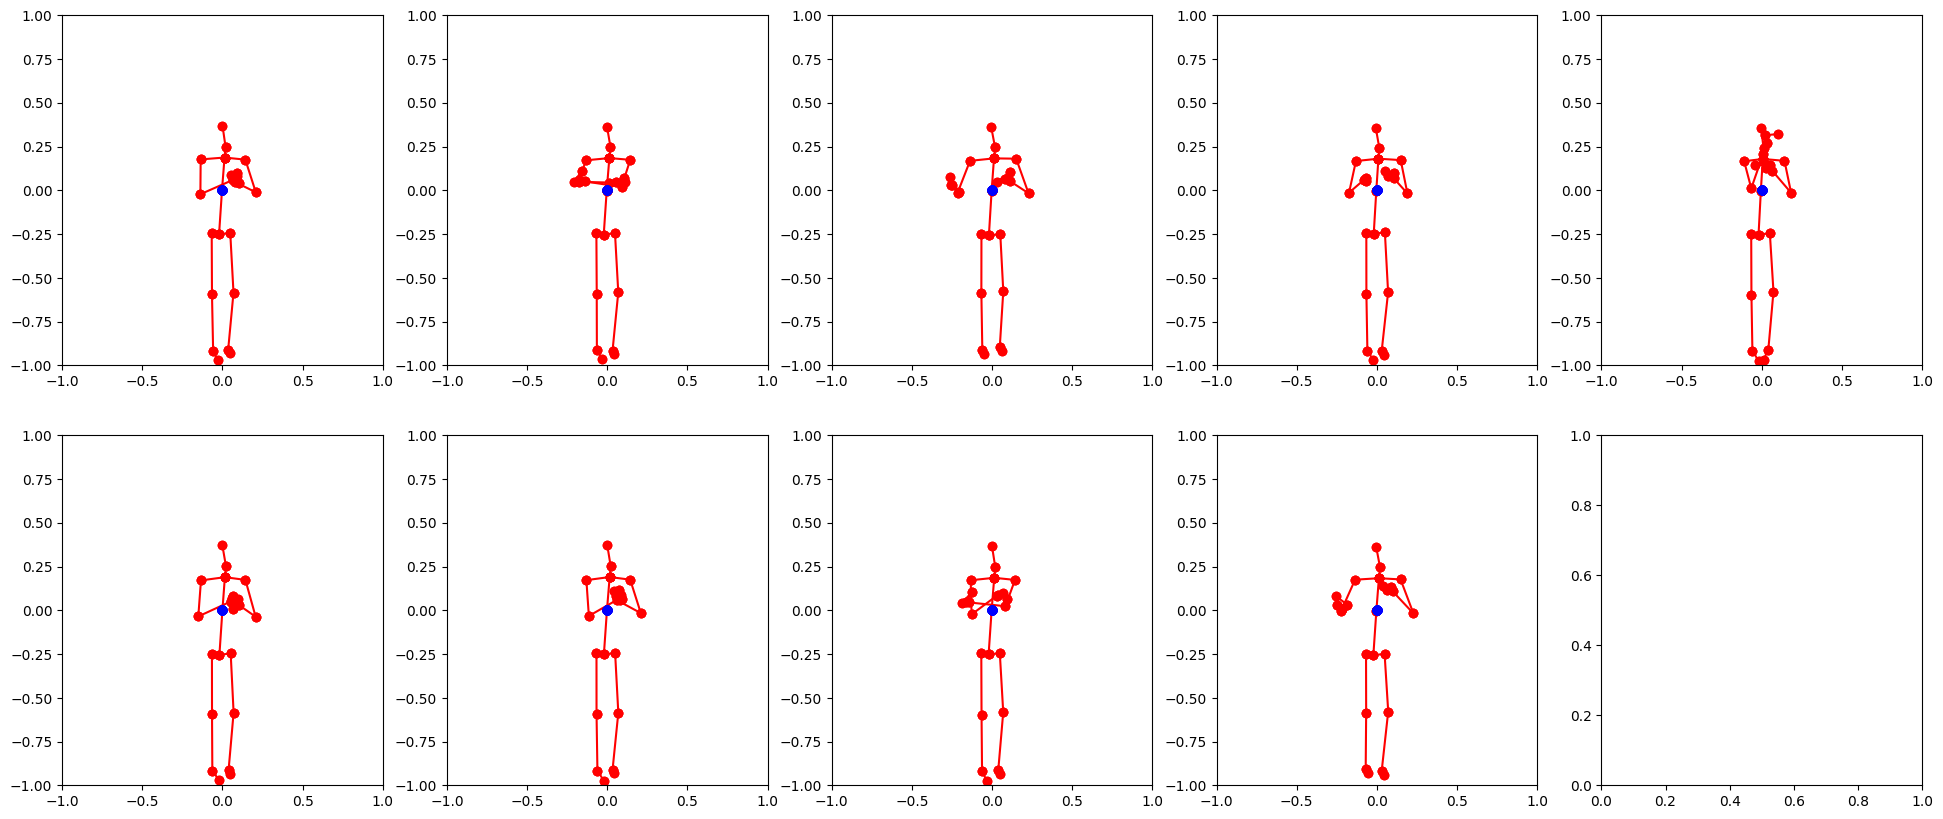

: 

In [91]:
# skeleton = np.random.rand(2, 100, 10, 3)  # 生成随机的骨架序列数据
idx = 12
skeleton = dataset[idx]['keypoint'][0].numpy()
label = dataset[idx]['label'][0].numpy()
print('label:' + label_dict[label.item()])
colors = ['red', 'blue', 'red', 'blue', 'red'] * 5
visualize_2d_skeleton(skeleton, colors=colors)

In [15]:
skeleton.min()

tensor(-0.9880)